In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

# Créer le dataframe

In [2]:

# Establish a connection to the database
conn = psycopg2.connect(
    host="localhost",
    database="ProjetBI",
    user="postgres",
    password="marwa"
)

In [3]:
# Create a cursor object
cur = conn.cursor()

# Execute the SQL query
cur.execute("SELECT stats.\"Job_Duration\", stats.\"Data_Volume\", (select count(\"Component_PK\") from public.\"DimJob\" join public.\"DimComponent\" on(public.\"DimJob\".\"Job_PK\" = public.\"DimComponent\".\"Job_FK\") where \"Job_PK\"=stats.\"Job_FK\" group by \"Job_Code\") as \"Nbr_Components\" FROM public.\"FactStats\" stats")
# Fetch all the rows as a list of tuples
rows = cur.fetchall()


In [4]:
# Convert the list of tuples to a pandas DataFrame
DF = pd.DataFrame(rows, columns=["Job_Duration","Data_Volume","Nbr_Components"])
print(DF)

       Job_Duration  Data_Volume  Nbr_Components
0             33447        39387               9
1             33447        39600               9
2             33447        39593               9
3             33447        39680               9
4             33447        41401               9
...             ...          ...             ...
11843         20993         3553               5
11844         20993         3554               5
11845         20993         3512               5
11846         20993         3482               5
11847         20993         3458               5

[11848 rows x 3 columns]


# Analyse descriptive max, min...


In [5]:
DF.describe()

,Job_Duration,Data_Volume,Nbr_Components
count,11848.000000,11848.000000,11848.000000
mean,26191.715986,31676.650236,5.269750
std,4164.527196,29515.402127,1.529813
min,17886.000000,1.000000,3.000000
25%,24692.000000,7950.000000,5.000000
50%,26496.000000,19606.000000,5.000000
75%,28605.000000,41910.000000,5.000000
max,33447.000000,101445.000000,9.000000


# Etude de Corrélation entre :
# -la durée et le volume
# -la durée et le nombre de composants du job


In [6]:
# normalize the data
scaler = MinMaxScaler()
DF = pd.DataFrame(scaler.fit_transform(DF), columns=DF.columns)
print(DF)

       Job_Duration  Data_Volume  Nbr_Components
0          1.000000     0.388254        1.000000
1          1.000000     0.390353        1.000000
2          1.000000     0.390284        1.000000
3          1.000000     0.391142        1.000000
4          1.000000     0.408107        1.000000
...             ...          ...             ...
11843      0.199666     0.035014        0.333333
11844      0.199666     0.035024        0.333333
11845      0.199666     0.034610        0.333333
11846      0.199666     0.034314        0.333333
11847      0.199666     0.034078        0.333333

[11848 rows x 3 columns]


Spearman correlation coefficient: 0.8608796170865032 - 0.49706253572804876
p-value:0.00000000000000000000
p-value:0.00000000000000000000


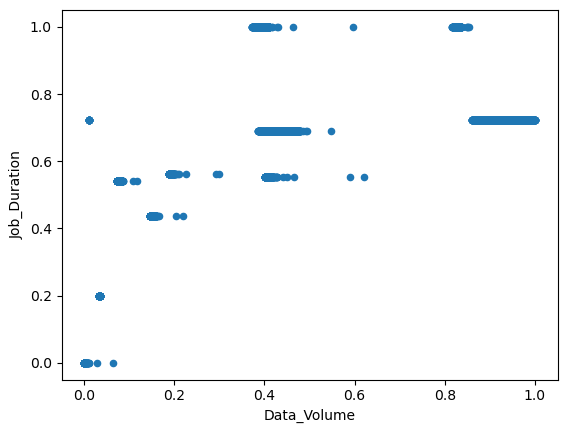

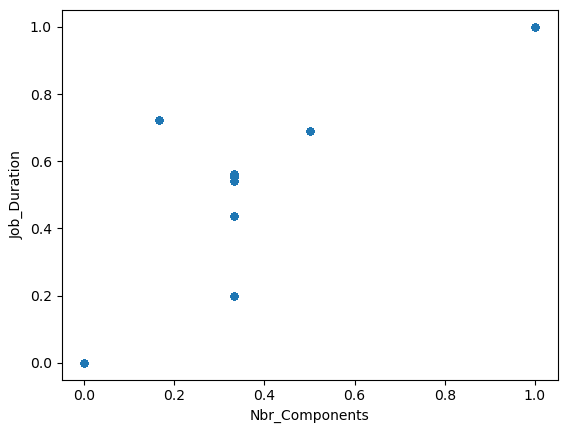

In [7]:
# create a scatter plot
DF.plot.scatter(x='Data_Volume', y='Job_Duration')
DF.plot.scatter(x='Nbr_Components', y='Job_Duration')

# calculate spearman correlation coefficient and p-value
corr1, pval1 = spearmanr(DF['Data_Volume'], DF['Job_Duration'])
corr2, pval2 = spearmanr(DF['Nbr_Components'], DF['Job_Duration'])

# print the correlation coefficient and p-value
print('Spearman correlation coefficient:', corr1, "-", corr2)
print('p-value:{:.20f}'.format(pval1))
print('p-value:{:.20f}'.format(pval2))


=> Relation non linéaire positive (faible/forte)?
p-value1 et p-value2 < 5% donc le coeff spearman est significatif


# Régression linéaire multiple


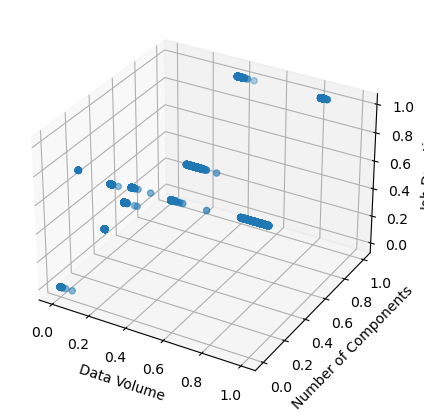

In [10]:
#Model Training

X = DF[['Data_Volume', 'Nbr_Components']]
y = DF['Job_Duration']
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# create a scatter plot of the training data

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['Data_Volume'], X_train['Nbr_Components'], y_train)
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()

R² :  0.8557298876103305
MSE :  0.010419144630916278


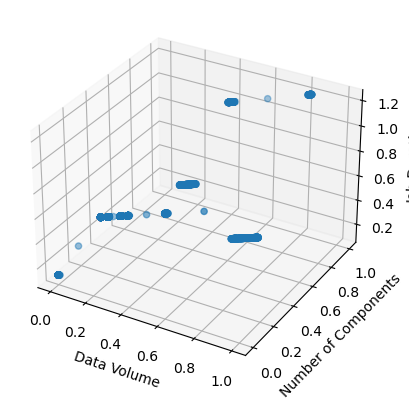

In [21]:
# create a LinearRegression object
model = LinearRegression()

# fit the model to the training data
model.fit(X_train, y_train)

# predict the y-values for the test data
y_pred = model.predict(X_test)

# calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R² : ",r2)

# calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE : ",mse)



# create a scatter plot of the test data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['Data_Volume'], X_test['Nbr_Components'], y_pred)
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()

In [22]:
# afficher l'équation du modèle
coef = model.coef_
intercept = model.intercept_

equation = 'Job_Duration = {:.2f} + {:.2f}*Data_Volume + {:.2f}*Nbr_Components'.format(intercept, coef[0], coef[1])
print(equation)

Job_Duration = 0.13 + 0.51*Data_Volume + 0.65*Nbr_Components


La valeur de R² de 0,8557298876103305 signifie que 85,57 % de la variance de la variable dépendante (Job_Duration) peut être expliquée par les variables indépendantes (Data_Volume et Nbr_Components) dans le modèle de régression linéaire.

La valeur MSE de 0,010419144630916278 représente l'erreur quadratique moyenne du modèle. Il s'agit d'une mesure de la différence quadratique moyenne entre les valeurs prédites et les valeurs réelles. Une valeur MSE plus faible indique un meilleur ajustement du modèle aux données.

Dans l'ensemble, une valeur de R² de 0,855 et une valeur de MSE de 0,0104 suggèrent que le modèle convient bien aux données et est un bon prédicteur de la durée de l'emploi donnée par le volume de données et le nombre de composants.